In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cplex
from cplex.exceptions import CplexError

import math

from qiskit.utils import algorithm_globals
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler

In [3]:
# Initialize the problem by defining the parameters
n = 5  # number of nodes + depot (n+1)
K = 4  # number of vehicles

In [4]:
#Get the data
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [5]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

In [6]:
class ClassicalOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles

    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n - self.K)

    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0]) + [0.0 for x in range(0, n - 1)]
        my_ub = [1 for x in range(0, n**2 + n - 1)]
        my_lb = [0 for x in range(0, n**2)] + [0.1 for x in range(0, n - 1)]
        my_ctype = "".join(["I" for x in range(0, n**2)]) + "".join(
            ["C" for x in range(0, n - 1)]
        )

        my_rhs = (
            2 * ([K] + [1 for x in range(0, n - 1)])
            + [1 - 0.1 for x in range(0, (n - 1) ** 2 - (n - 1))]
            + [0 for x in range(0, n)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 2 * n)])
            + "".join(["L" for x in range(0, (n - 1) ** 2 - (n - 1))])
            + "".join(["E" for x in range(0, n)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]
            rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + ii, n**2, n)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0, n):
                if (ii != jj) and (ii * jj > 0):

                    col = [ii + (jj * n), n**2 + ii - 1, n**2 + jj - 1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0, n):
            col = [(ii) * (n + 1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [7]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance, n, K)

# Print number of feasible solutions
print("Number of feasible solutions = " + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 5.0


In [8]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x, classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii // n != ii % n]
    # Print the solution
    print(z)
except:
    print("CPLEX may be missing.")

[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


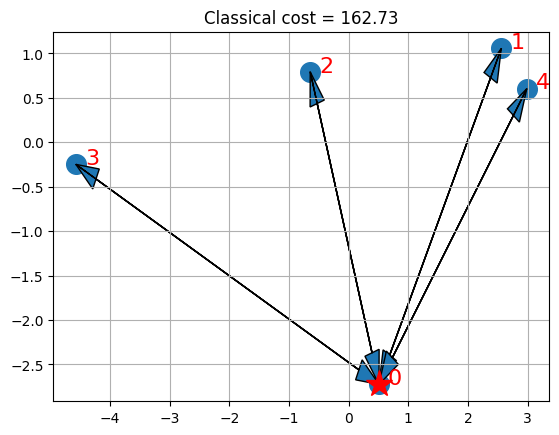

In [9]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=20)

    plt.grid()

    for ii in range(0, n**2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(
                xc[ix],
                yc[ix],
                xc[iy] - xc[ix],
                yc[iy] - yc[ix],
                length_includes_head=True,
                head_width=0.25,
            )

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()


if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, "Classical")

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

In [11]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="506dba7af62eb15fac05f5b674883038bc09fd4827b8b1de7c8b8bb8fb6799e3b687d0c3a3a78e188878a2465c12e9714a8e112001db319ffd54710090ec8d8c",overwrite=True)

In [12]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

In [13]:
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.optimizers import COBYLA,SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import PauliSumOp

class QuantumOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n
        self.K = K

    def binary_representation(self, x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n**2)
        w_list = [instance_vec[x] for x in range(n**2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for ii in range(n):
            count = ii - 1
            for jj in range(n * (n - 1)):

                if jj // (n - 1) == ii:
                    count = ii

                if jj // (n - 1) != ii and jj % (n - 1) == count:
                    v[ii][jj] = 1.0

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = (
            w
            - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T)
            - 2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)
        )

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K**2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = (
                lambda x: np.dot(np.around(x), np.dot(Q, np.around(x)))
                + np.dot(g, np.around(x))
                + c
            )
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem(self, qp):
        algorithm_globals.random_seed = 10598
    
        # Define the mixer Hamiltonian as a TwoLocal circuit
        mixer = TwoLocal(num_qubits=n * (n - 1), rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=3)

        # we're using COBYLA as the optimizer for the QAOA algorithm, specifying a total of three layers for the circuit, and using the TwoLocal ansatz with ry and rz rotations and cz entangling gates.
        qaoa = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=10, sampler=Sampler(session=backend), optimizer=SPSA(), mixer=mixer))
        result = qaoa.solve(qp)
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation(x_sol=result.x)
        return result.x, level

In [14]:
quantum_optimizer = QuantumOptimizer(instance, n, K)

In [15]:
try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol=z)
        print("Binary cost:", binary_cost, "classical cost:", classical_cost)
        if np.abs(binary_cost - classical_cost) < 0.01:
            print("Binary formulation is correct")
        else:
            print("Error in the binary formulation")
    else:
        print("Could not verify the correctness, due to CPLEX solution being unavailable.")
        Q, g, c, binary_cost = quantum_optimizer.binary_representation()
        print("Binary cost:", binary_cost)
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

Binary cost: 162.7373164978635 classical cost: 162.73731649784793
Binary formulation is correct


In [16]:
qp = quantum_optimizer.construct_problem(Q, g, c)

In [17]:
quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)

print(quantum_solution, 
      quantum_cost)

[0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.] 23275.406591551437


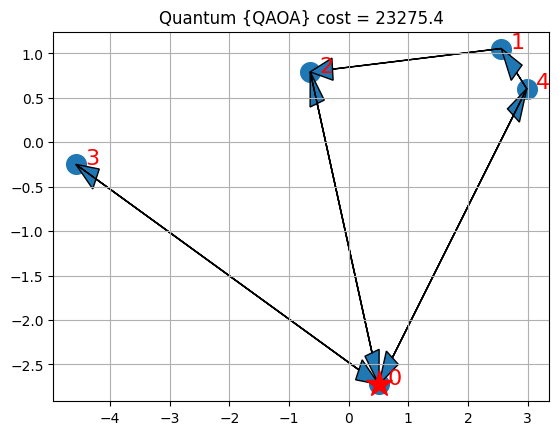

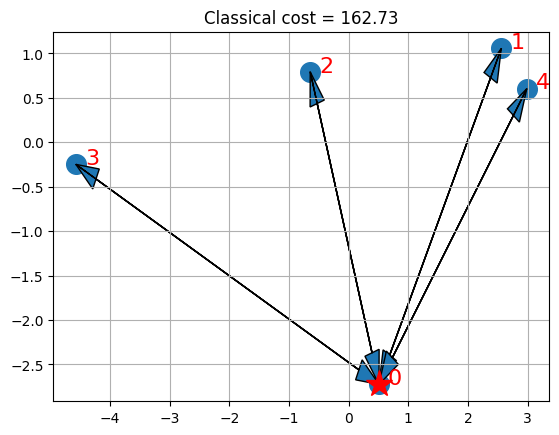

In [18]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk += 1

# visualize the solution
visualize_solution(xc, yc, x_quantum, quantum_cost, n, K, "Quantum {QAOA}")

# and visualize the classical for comparison
if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, "Classical")